# TP 2

### Alumno: Javier Villagra

Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.

In [1]:
import numpy as np
import cv2

def create_gauss_filter(h, w, k_size, sigma):
    # Crea el filtro gaussiano en el dominio espacial
    gauss_kernel = cv2.getGaussianKernel(k_size, sigma)

    # Crea la matriz en base al vector que devuelve getGaussianKernel(k_size, sigma)
    gauss_matrix = np.outer(gauss_kernel, gauss_kernel.T)

    # Centra el filtro gaussiano en una matriz de tamaño h x w rellena de 0
    centered_gauss = np.zeros((h, w), dtype=np.float32)
    start_row = (h - k_size) // 2
    start_col = (w - k_size) // 2
    centered_gauss[start_row:start_row+k_size, start_col:start_col+k_size] = gauss_matrix

    # Aplico la transformada de Fourier al filtro gaussiano
    fft_result = np.fft.fft2(centered_gauss)
    #fft_result_shifted = np.fft.fftshift(fft_result)

    return centered_gauss, fft_result


1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro a una imagen para validar el funcionamiento en el dominio espectral.

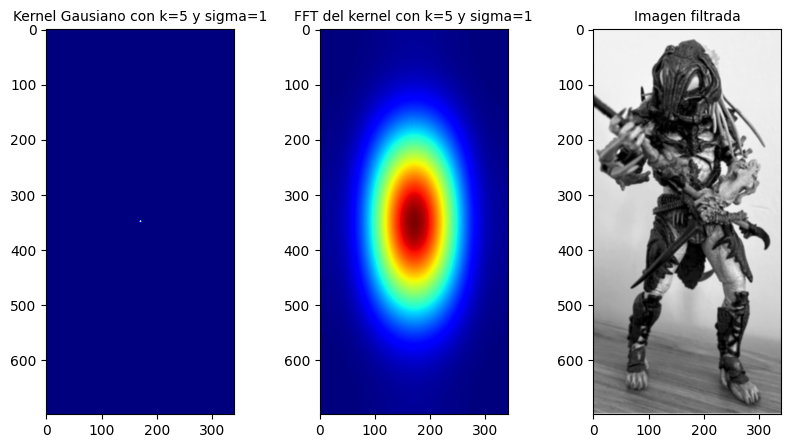

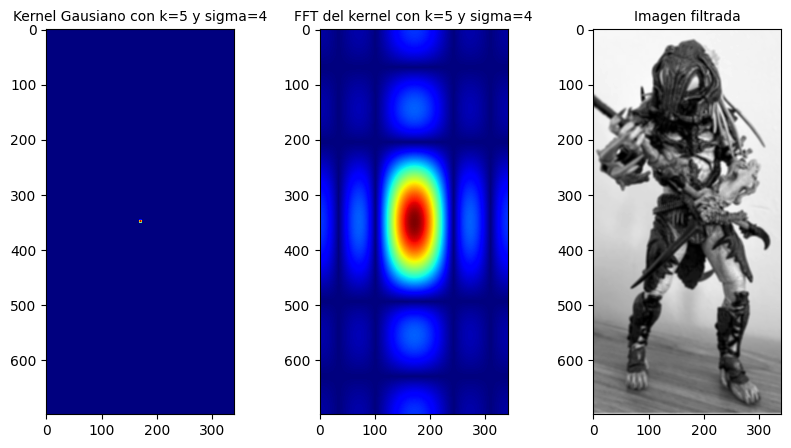

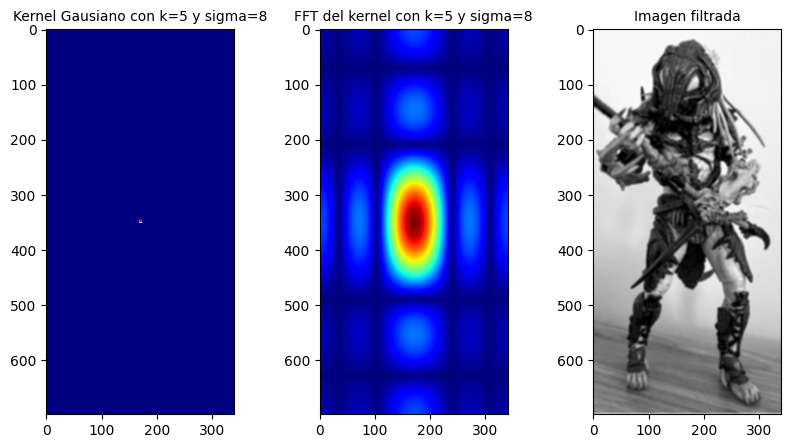

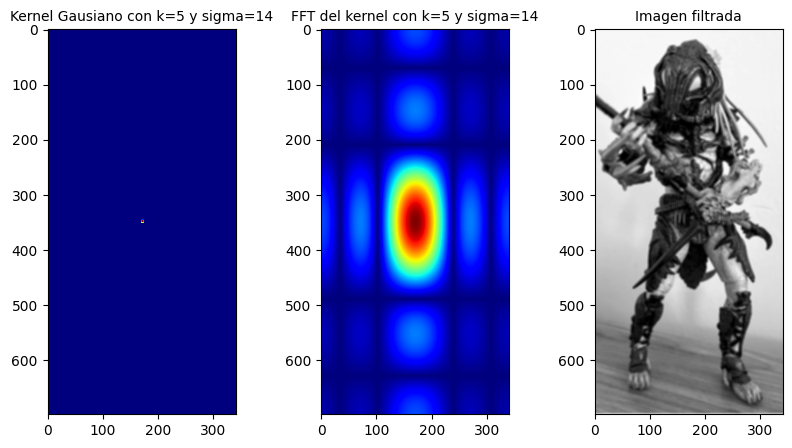

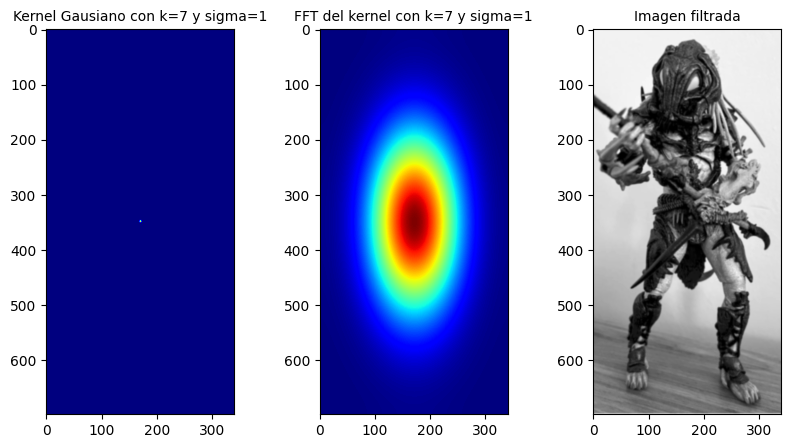

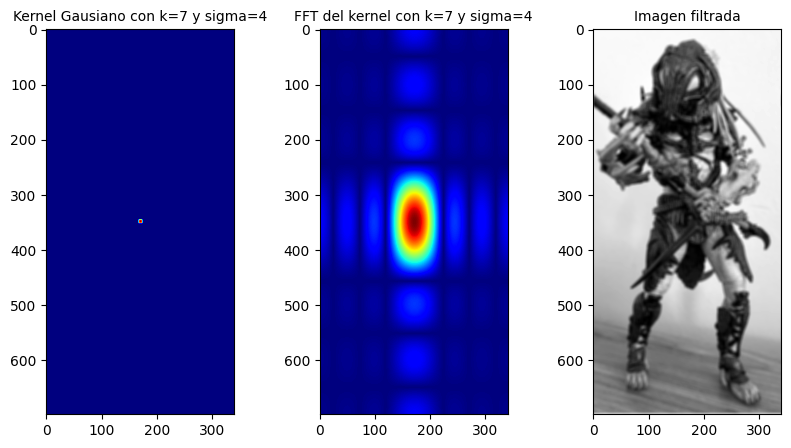

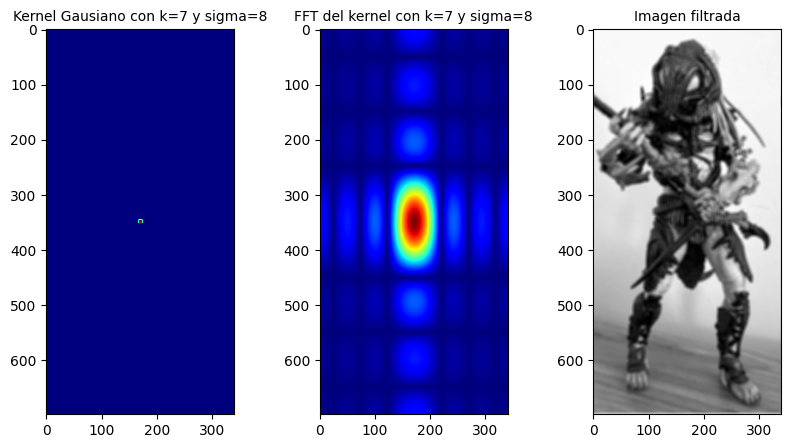

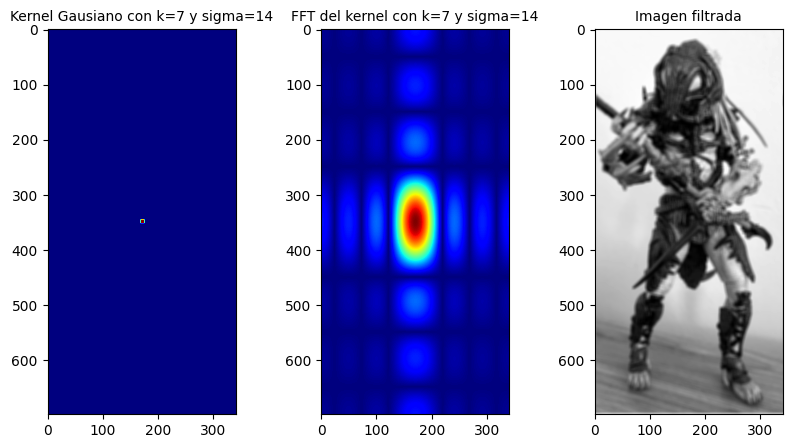

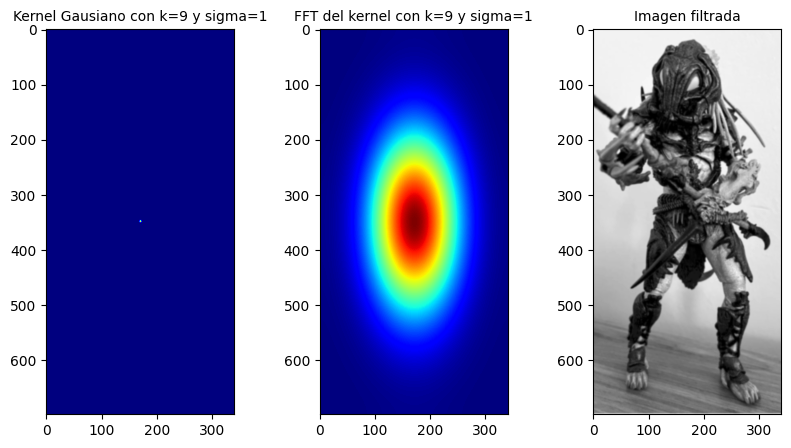

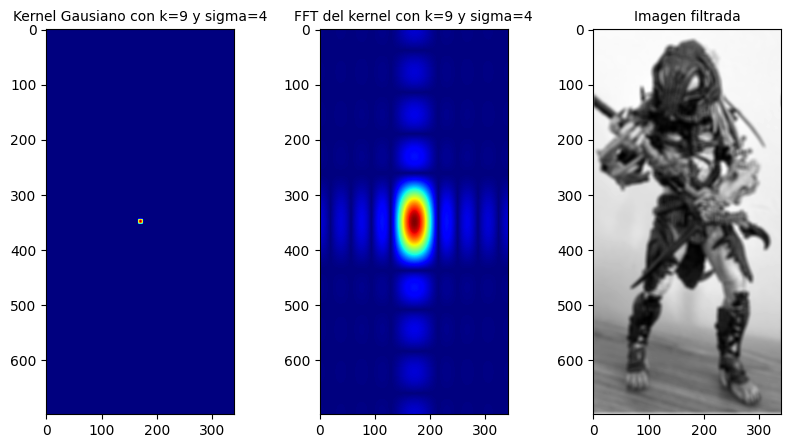

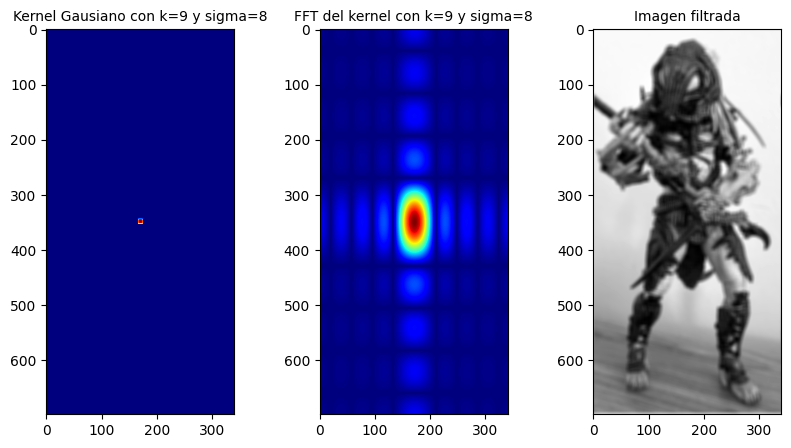

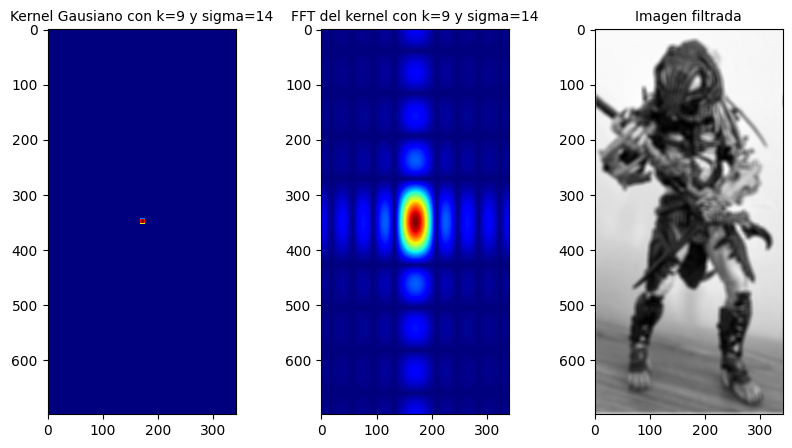

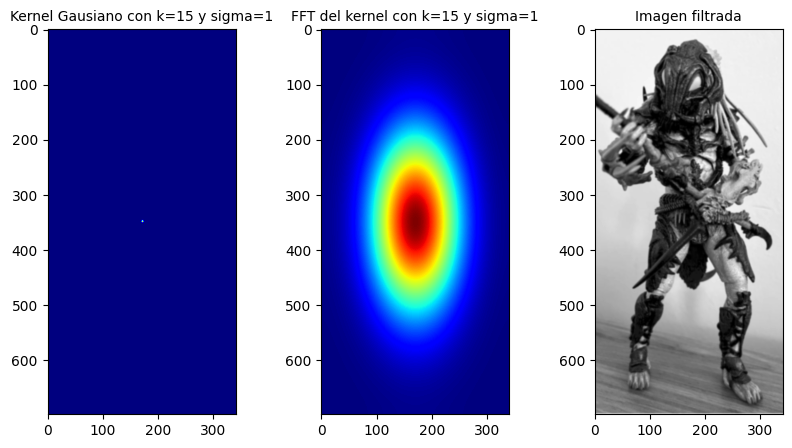

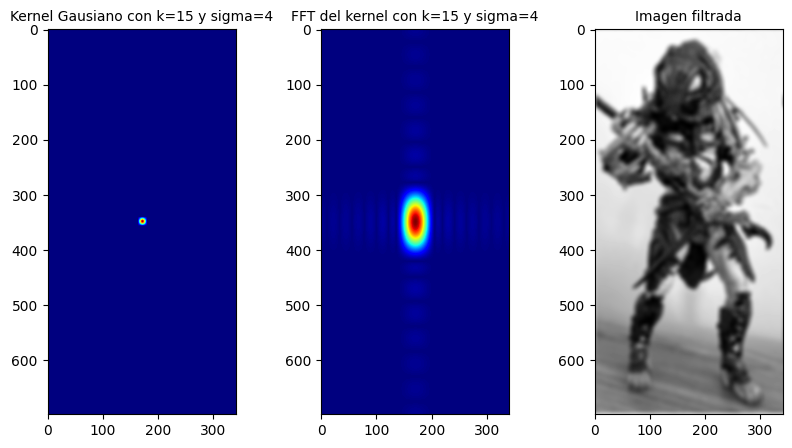

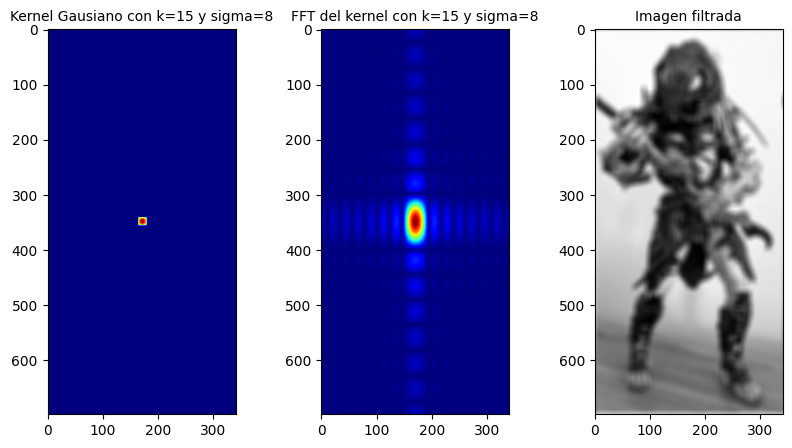

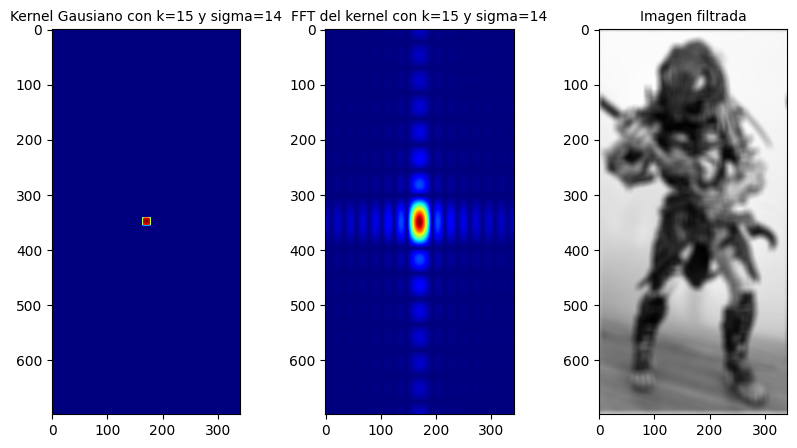

In [2]:
import matplotlib.pyplot as plt
import cv2 as cv


img = cv.imread('resources/fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
h, w = img.shape

k_sizes = [5, 7, 9, 15]
sigmas = [1, 4, 8, 14]

for k_size in k_sizes:
    for sigma in sigmas:

        kernel, kernel_fft = create_gauss_filter(h, w, k_size, sigma)
        fontsize=10
        
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        axs[0].set_title(f"Kernel Gausiano con k={k_size} y sigma={sigma}", fontsize=fontsize)
        axs[0].imshow(kernel, cmap='jet')

        axs[1].set_title(f"FFT del kernel con k={k_size} y sigma={sigma}", fontsize=fontsize)
        tf_shifted = np.fft.fftshift(kernel_fft)
        axs[1].imshow(np.abs(tf_shifted), cmap='jet')

        img_fft = np.fft.fft2(img)
        filtered = img_fft * kernel_fft
        img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
        axs[2].set_title("Imagen filtrada", fontsize=fontsize)
        axs[2].imshow(img_gauss, cmap='gray')



2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [3]:
def fm_image_quality_measure(image):
    
    # Step 1: Compute the Fourier Transform (F) of the image
    F = np.fft.fft2(image)

    # Step 2: Shift the origin of F to the center (Fc)
    Fc = np.fft.fftshift(F)

    # Step 3: Calculate the absolute value of the centered Fourier transform (AF)
    AF = np.abs(Fc)

    # Step 4: Calculate the maximum value of the frequency component in F (M)
    M = np.max(AF)

    # Step 5: Calculate the threshold value (threshold)
    threshold = M / 1000

    # Step 6: Count the number of pixels in F whose value is greater than thres (TH)
    Th = np.sum(AF > threshold)

    # Calculate the Image Quality measure (FM)
    FM = Th / (image.shape[0] * image.shape[1])

    return FM


# Correspondiente al punto 3

def absolute_central_moment(image):
    # Convert the image to grayscale if not
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Calculate the image histogram
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0,256])

    # Step 2: Calculate the probability of each gray level
    pks = hist / float(np.sum(hist))

    # Step 3: Calculate the mean gray intensity (mu)
    mu = np.sum(np.arange(256) * pks)

    # Calculate ACMo
    ACMo = np.sum(np.abs(np.arange(256) - mu) * pks)

    return ACMo

Se realiza la comparación del resultado del filtrado por convolución contra el filtrado espectral con k fijo.

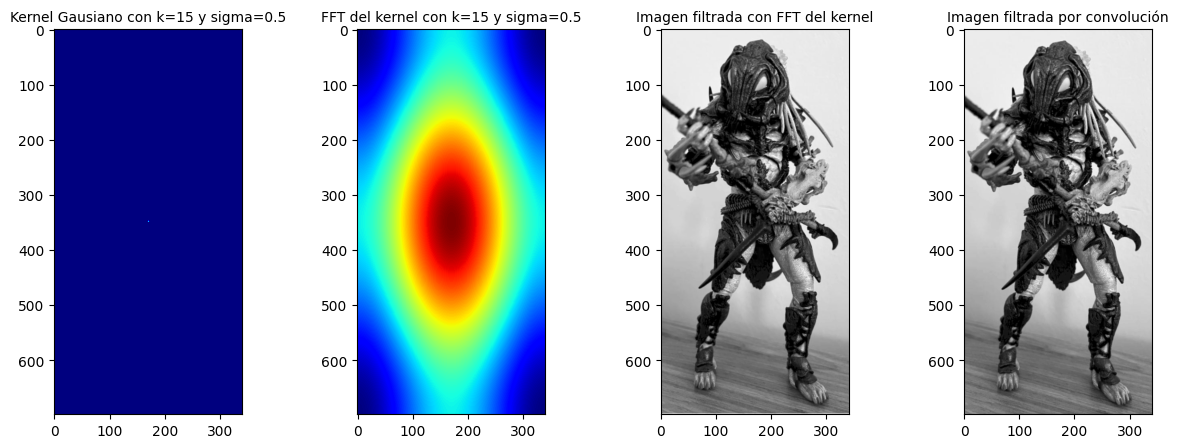

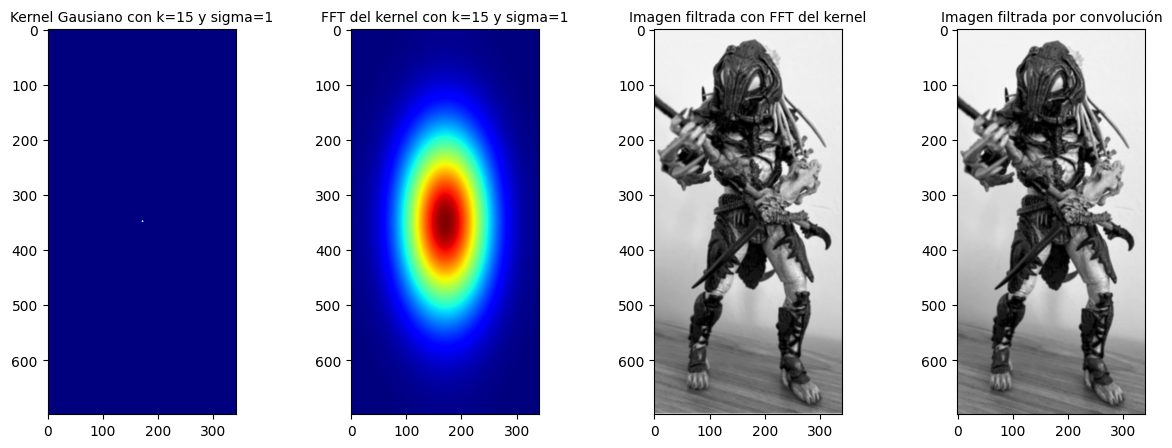

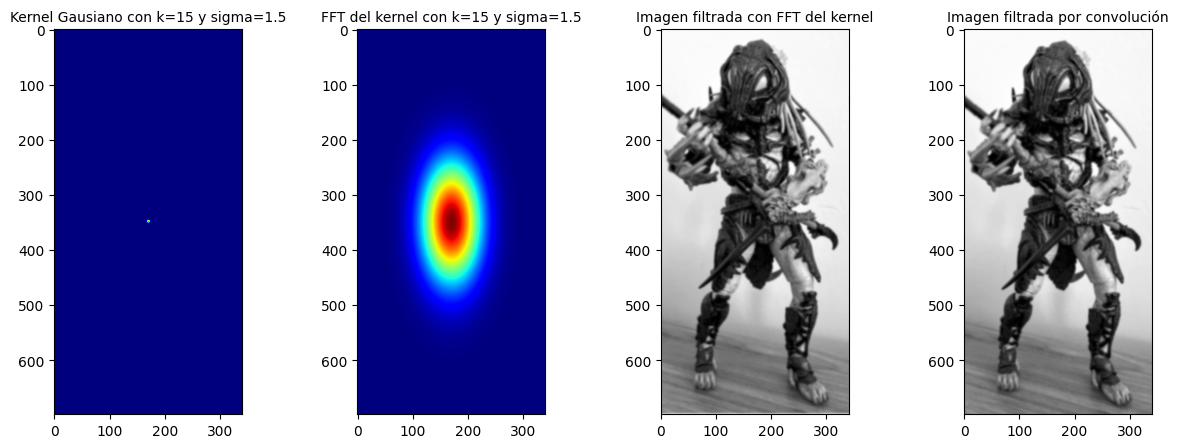

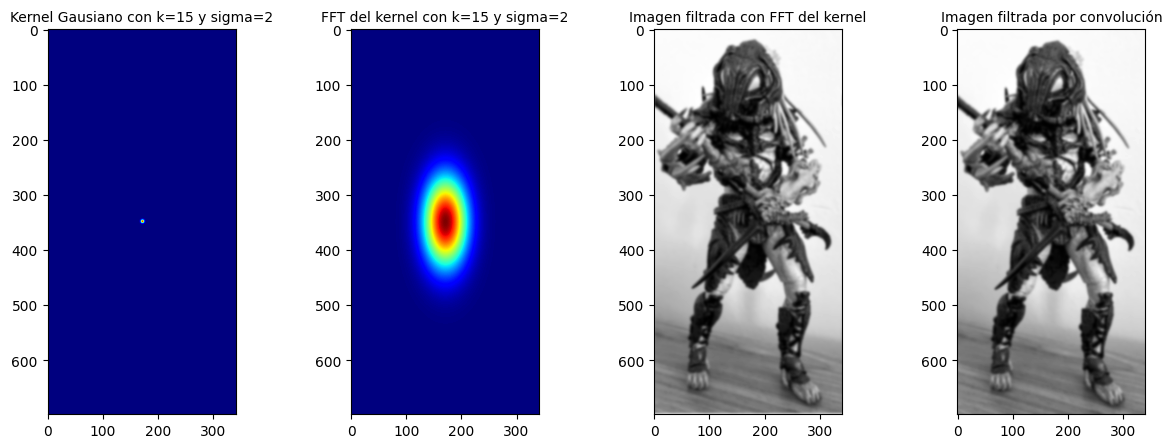

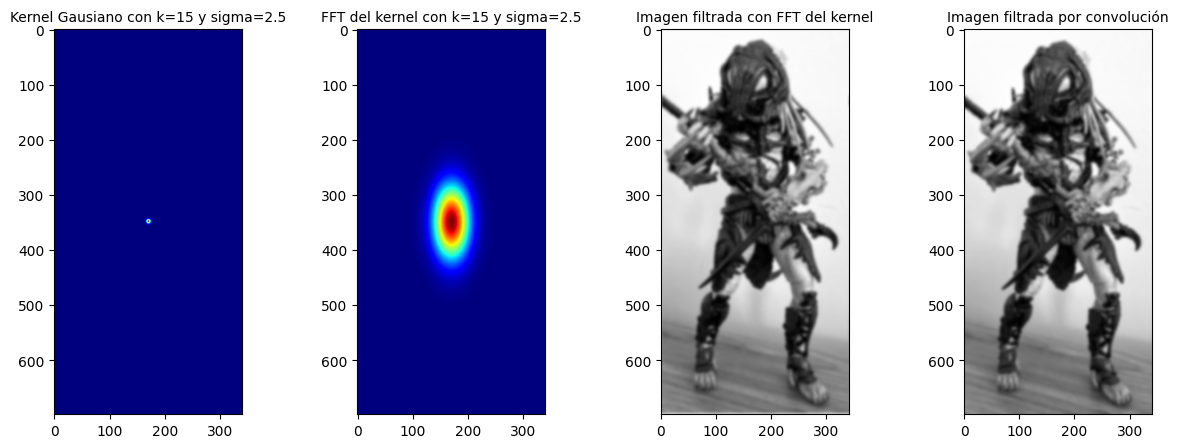

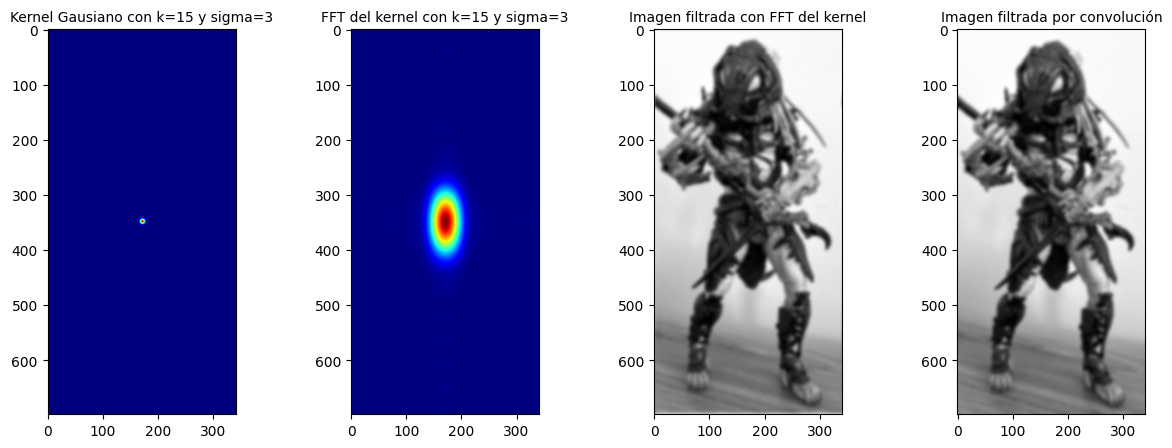

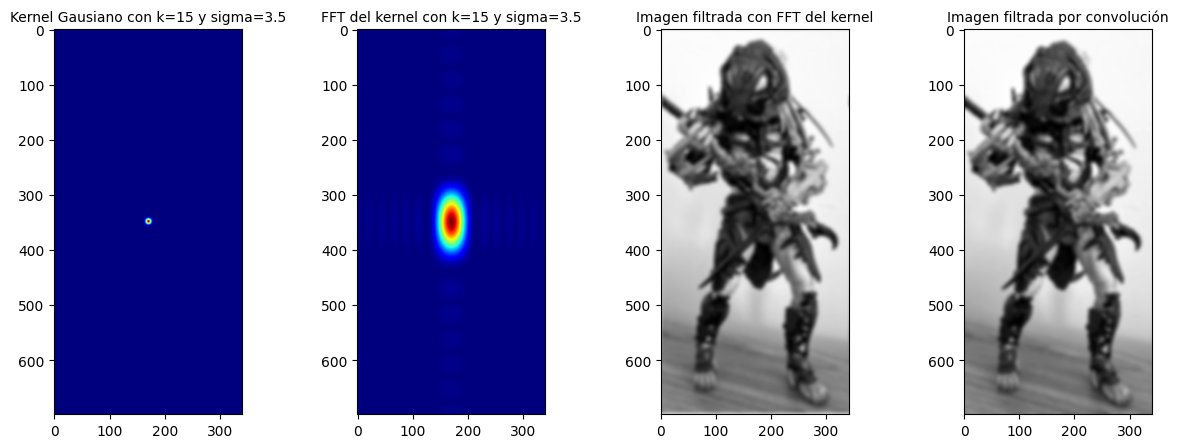

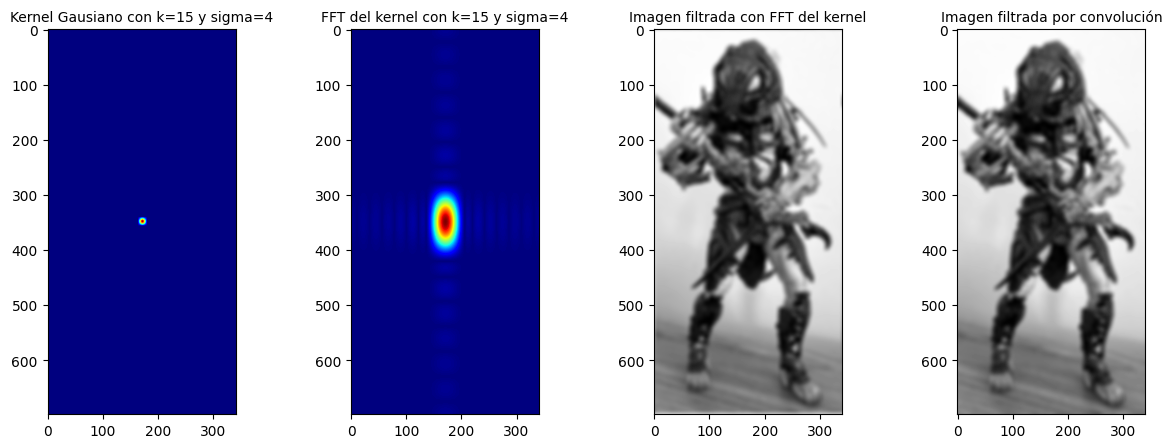

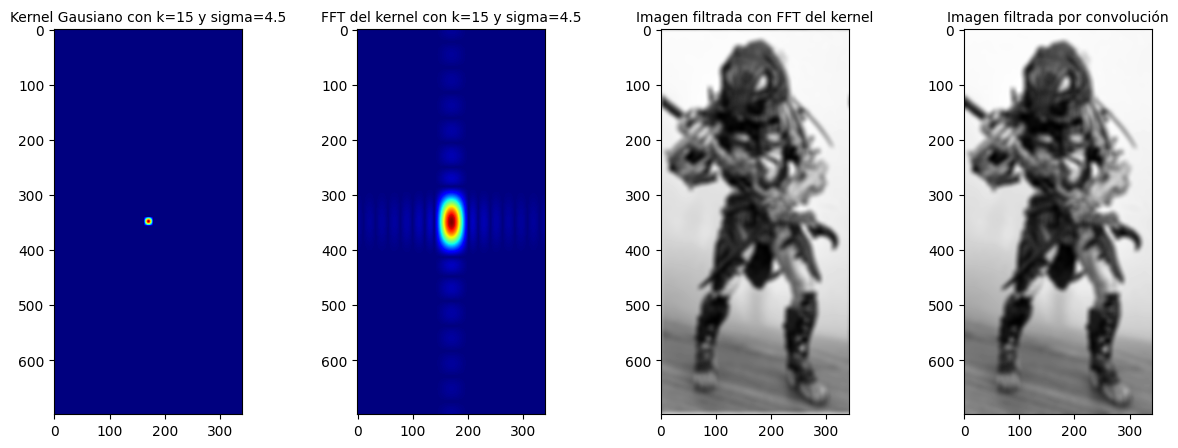

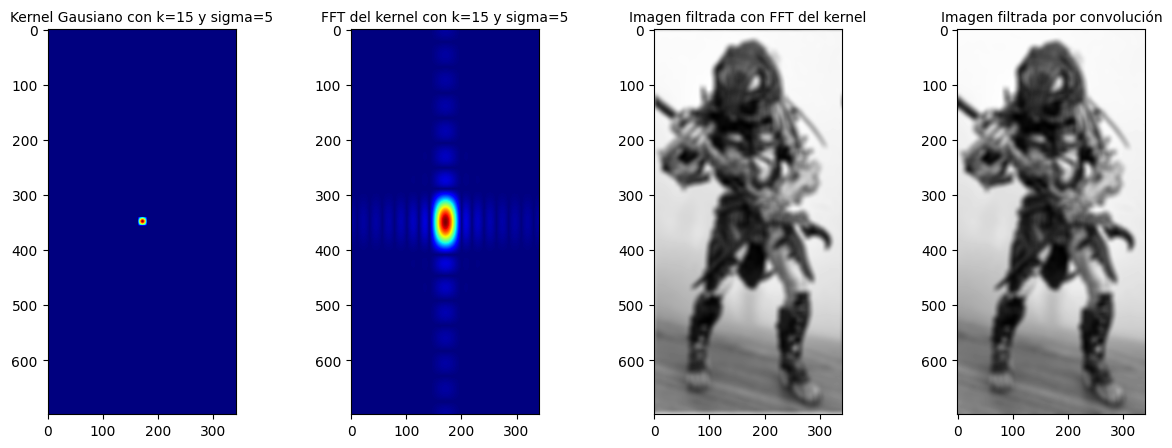

In [4]:
k_sizes = 15
sigmas = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

fft_fm_measure = []
conv_fm_measure = []

fft_acmo_measure = []
conv_acmo_measure = []

for sigma in sigmas:

    kernel, kernel_fft = create_gauss_filter(h, w, k_size, sigma)
    fontsize=10
    
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    axs[0].set_title(f"Kernel Gausiano con k={k_size} y sigma={sigma}", fontsize=fontsize)
    axs[0].imshow(kernel, cmap='jet')

    axs[1].set_title(f"FFT del kernel con k={k_size} y sigma={sigma}", fontsize=fontsize)
    tf_shifted = np.fft.fftshift(kernel_fft)
    axs[1].imshow(np.abs(tf_shifted), cmap='jet')

    img_fft = np.fft.fft2(img)
    filtered_fft = img_fft * kernel_fft
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered_fft)))
    axs[2].set_title("Imagen filtrada con FFT del kernel", fontsize=fontsize)
    axs[2].imshow(img_gauss, cmap='gray')

    img_gauss_conv = cv2.filter2D(img, -1, kernel)
    axs[3].set_title("Imagen filtrada por convolución", fontsize=fontsize)
    axs[3].imshow(img_gauss_conv, cmap='gray')

    # Measuring FM
    fft_fm_measure.append((sigma, fm_image_quality_measure(img_gauss)))
    conv_fm_measure.append((sigma, fm_image_quality_measure(img_gauss_conv))) 

    # Punto 3 - Measuring ACMo
    fft_acmo_measure.append((sigma, absolute_central_moment(img_gauss)))
    conv_acmo_measure.append((sigma, absolute_central_moment(img_gauss_conv))) 


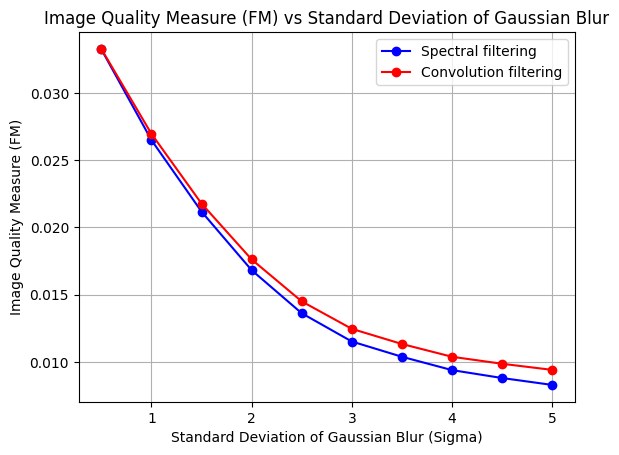

In [5]:
# Dividing the tuples for plotting

x_fft_fm_measure, y_fft_fm_measure = zip(*fft_fm_measure)
x_conv_fm_measure, y_conv_fm_measure = zip(*conv_fm_measure)

#fig, axs = plt.subplots(1, 1, figsize=(25, 15))
plt.plot(x_fft_fm_measure, y_fft_fm_measure, marker='o', linestyle='-', color='b', label="Spectral filtering")
plt.plot(x_conv_fm_measure, y_conv_fm_measure, marker='o', linestyle='-', color='r', label="Convolution filtering")
plt.title('Image Quality Measure (FM) vs Standard Deviation of Gaussian Blur')
plt.xlabel('Standard Deviation of Gaussian Blur (Sigma)')
plt.ylabel('Image Quality Measure (FM)')
plt.legend()
plt.grid(True)
plt.show()

3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”

Se empleará Absolute central moment (ACMo) de Shirvaikar et al. como medición de foco. El método está descrito en la sección correspondiente a la pregunta 2 a fin de no volver a iterar sobre el arreglo de sigmas.

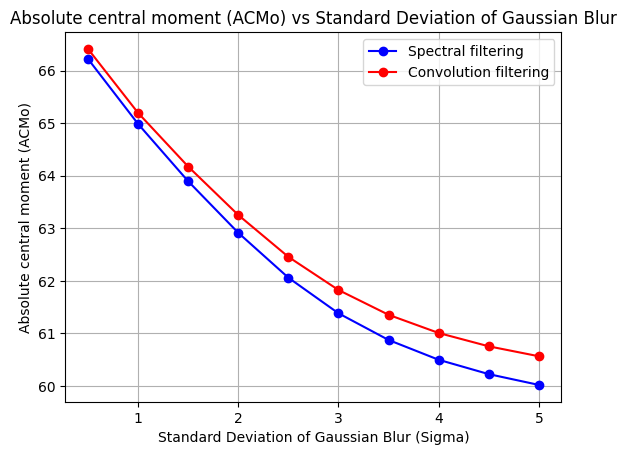

In [6]:
# Dividing the tuples for plotting

x_fft_acmo_measure, y_fft_acmo_measure = zip(*fft_acmo_measure)
x_conv_acmo_measure, y_conv_acmo_measure = zip(*conv_acmo_measure)

#fig, axs = plt.subplots(1, 1, figsize=(25, 15))
plt.plot(x_fft_acmo_measure, y_fft_acmo_measure, marker='o', linestyle='-', color='b', label="Spectral filtering")
plt.plot(x_conv_acmo_measure, y_conv_acmo_measure, marker='o', linestyle='-', color='r', label="Convolution filtering")
plt.title('Absolute central moment (ACMo) vs Standard Deviation of Gaussian Blur')
plt.xlabel('Standard Deviation of Gaussian Blur (Sigma)')
plt.ylabel('Absolute central moment (ACMo)')
plt.legend()
plt.grid(True)
plt.show()